In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from rnn import RNNNet
from dataset import StimuliDataset

In [2]:
color_blue = "#fd7f6f"
color_green = "#7eb0d5"
color_yellow = "#8bd3c7"
color_orange = "#bd7ebe"
color_red = "#ffb55a"
color_purple = "#ffee65"


In [24]:
#loads the model
hidden_size = 128
input_size = 13
output_size = 6
dt = 0.1
tau = 100
batch_size = 1
model_path = './long_model.pt'
num_trials = 500
stimulus_duration = 8

net = RNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=dt, tau=tau)
net.load_state_dict(torch.load(model_path))
# Check if a GPU is available
device = torch.device("cpu")

# Move the network to the device
net = net.to(device)

print(num_trials)
dataset = StimuliDataset(num_trials)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

500


In [27]:
stimulus_activity_dict = {}
decision_activity_dict = {}
attended_info = {}
diff_shape={} 
for i, (stimulus, labels) in enumerate(dataloader):
            labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)
            stimuli = np.stack([stimulus] * stimulus_duration, axis=1)
            stop_cue = np.zeros((batch_size,1,input_size))
            inputs  = np.concatenate((stimuli, stop_cue), axis=1)
            attended_info[i] = inputs[0][0][-1] #records the trial-specific attentional cue                
            inputs = torch.from_numpy(inputs).float().to(device)
            labels = labels.float().to(device)  # Convert labels to long and move to device

            output, rnn_activity = net(inputs.permute(1, 0, 2))
            if (attended_info[i]>0):
                if (torch.argmax(output, dim=1).item() == labels.item()):
                    diff_shape[i] = 1
                else:
                    diff_shape[i] = 0
                    
            
            rnn_activity = rnn_activity[:, 0, :].detach().numpy()
            stimulus_activity_dict[i] = rnn_activity[:stimulus_duration][:]
            decision_activity_dict[i] = np.expand_dims(rnn_activity[-1][:], axis=0)
print("finished")

/tmp/ipykernel_2184002/1657227677.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)


finished


In [28]:
attended_trials_stimulus = []
attended_trials_decision = []
unattended_trials_stimulus = []
unattended_trials_decision = []
for i in range(len(attended_info)):
        if (attended_info[i] > 0):
                attended_trials_stimulus.append(stimulus_activity_dict[i])
                attended_trials_decision.append(decision_activity_dict[i])
        else:
                unattended_trials_stimulus.append(stimulus_activity_dict[i])
                unattended_trials_decision.append(decision_activity_dict[i])
                
                
attended_trials_num = len(attended_trials_stimulus)
unattended_trials_num = len(unattended_trials_stimulus)

attended_trials_stimulus = np.concatenate(list(attended_trials_stimulus[i] for i in range(attended_trials_num)), axis=0)
attended_trials_decision = np.concatenate(list(attended_trials_decision[i] for i in range(attended_trials_num)), axis=0)
unattended_trials_stimulus = np.concatenate(list(unattended_trials_stimulus[i] for i in range(unattended_trials_num)), axis=0)
unattended_trials_decision = np.concatenate(list(unattended_trials_decision[i] for i in range(unattended_trials_num)), axis=0)

In [29]:
# Compute PCA and visualize
from sklearn.decomposition import PCA

pca_attended_stimulus = PCA(n_components=6)
pca_attended_stimulus.fit(attended_trials_stimulus)

pca_unattended_stimulus = PCA(n_components=6)
pca_unattended_stimulus.fit(unattended_trials_stimulus)

PCA(n_components=6)

In [31]:
stimulus_activity_dict = {}
decision_activity_dict = {}
attended_info = {} 

diff_object={}  #only records attended trials
for i, (stimulus, labels) in enumerate(dataloader):
            labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)
            stimuli = np.stack([stimulus] * stimulus_duration, axis=1)
            stop_cue = np.zeros((batch_size,1,input_size))
            inputs  = np.concatenate((stimuli, stop_cue), axis=1)
            attended_info[i] = inputs[0][0][-1] #records the trial-specific attentional cue                
            inputs = torch.from_numpy(inputs).float().to(device)
            labels = labels.float().to(device)  # Convert labels to long and move to device

            output, rnn_activity = net(inputs.permute(1, 0, 2))
            if (attended_info[i]==0):
                    diff_object[i] = np.where(inputs[0][0][:] == 1.0)[0][0]-6            
            rnn_activity = rnn_activity[:, 0, :].detach().numpy()
            stimulus_activity_dict[i] = rnn_activity[:stimulus_duration][:]
            decision_activity_dict[i] = np.expand_dims(rnn_activity[-1][:], axis=0)
print("finished")

/tmp/ipykernel_2184002/3507981629.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)


finished


Text(0, 0.5, 'PC 1')

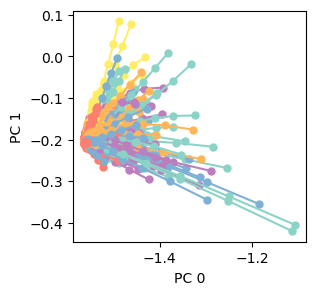

In [33]:
#projecting unattended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 1], 'o-',color = color, markersize=5)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 1')

Text(0, 0.5, 'PC 2')

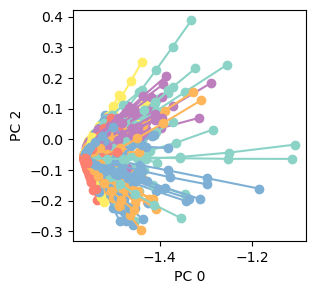

In [34]:
#same as above but using diff PC's

#projecting unattended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 2], 'o-',color = color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 2')

Text(0, 0.5, 'PC 2')

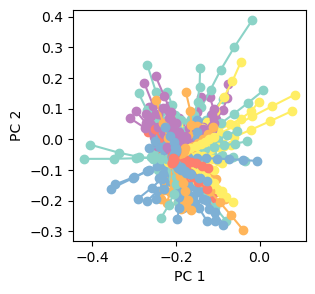

In [35]:
#same as above but using diff PC's

#projecting unattended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 1], attended_stimulus_activity_pc[:, 2], 'o-',color = color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

Text(0, 0.5, 'PC 4')

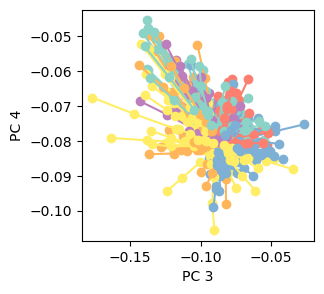

In [12]:
#same as above but using diff PC's

# projecting unattended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 3], attended_stimulus_activity_pc[:, 4], 'o-',color = color)

ax1.set_xlabel('PC 3')
ax1.set_ylabel('PC 4')

Text(0, 0.5, 'PC 3')

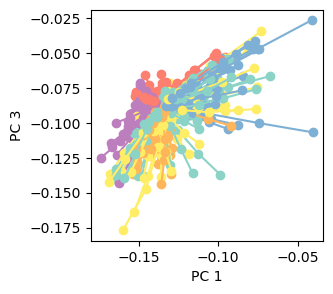

In [13]:
#same as above but using diff PC's

#projecting unattended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 1], attended_stimulus_activity_pc[:, 3], 'o-',color = color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 3')

Text(0, 0.5, 'PC 1')

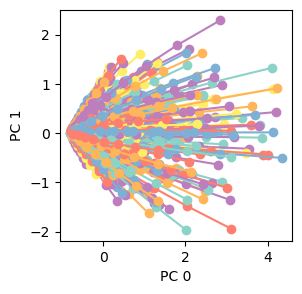

In [36]:
#projecting unattended trials onto unattended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0):
        attended_stimulus_activity_pc = pca_unattended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange  

        _ = ax1.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 1], 'o-',color = color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 1')

Text(0, 0.5, 'PC 2')

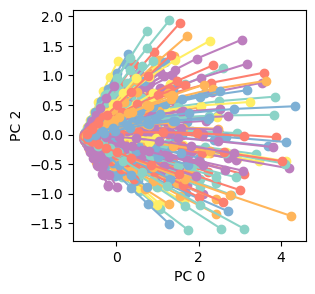

In [37]:
#projecting unattended trials onto unattended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0): 
        attended_stimulus_activity_pc = pca_unattended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange  

        _ = ax1.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 2], 'o-',color = color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 2')

Text(0, 0.5, 'PC 2')

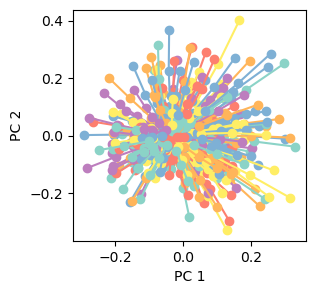

In [16]:
#projecting unattended trials onto unattended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0):
        attended_stimulus_activity_pc = pca_unattended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange  

        _ = ax1.plot(attended_stimulus_activity_pc[:, 1], attended_stimulus_activity_pc[:, 2], 'o-',color = color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

Text(0, 0.5, 'PC 4')

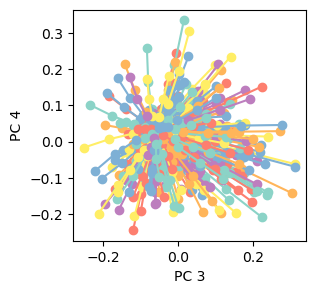

In [19]:
#projecting unattended trials onto unattended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0):
        attended_stimulus_activity_pc = pca_unattended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange  

        _ = ax1.plot(attended_stimulus_activity_pc[:, 3], attended_stimulus_activity_pc[:, 4], 'o-',color = color)

ax1.set_xlabel('PC 3')
ax1.set_ylabel('PC 4')

Text(0, 0.5, 'PC 4')

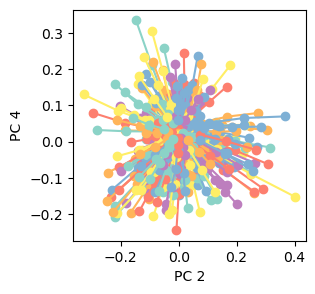

In [20]:
#projecting unattended trials onto unattended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] == 0):
        attended_stimulus_activity_pc = pca_unattended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = color_red
        if (diff_object[i] == 1):
            color = color_green 
        if (diff_object[i] == 2):
            color = color_blue 
        if (diff_object[i] == 3):
            color = color_purple 
        if (diff_object[i] == 4):
            color = color_yellow 
        if (diff_object[i] == 5):
            color = color_orange  

        _ = ax1.plot(attended_stimulus_activity_pc[:, 2], attended_stimulus_activity_pc[:, 4], 'o-',color = color)

ax1.set_xlabel('PC 2')
ax1.set_ylabel('PC 4')